In [3]:
!nvidia-smi

Thu Jul 23 00:45:55 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN RTX           Off  | 00000000:04:00.0 Off |                  N/A |
| 41%   50C    P2   104W / 280W |  14389MiB / 24220MiB |     82%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN RTX           Off  | 00000000:05:00.0 Off |                  N/A |
| 52%   74C    P2   154W / 280W |  12904MiB / 24220MiB |     75%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [4]:
######### IMPORTING NECESSARY MODULES #########
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, TensorDataset
import sys
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data
from torchvision import transforms, datasets, models
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import os
import pandas as pd

In [5]:
device = torch.device('cuda:4' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:4


In [19]:
#transformation for Images 

data_transform = transforms.Compose([   transforms.Scale((224)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])
                                            ])

#CUSTOM DATASET CREATION FROM .csv file
class Customdataset(Dataset):
    def __init__(self, txt_file, root_dir, transform=data_transform):

        self.img_pair = pd.read_csv(txt_file, sep=",", engine='python', header=None, error_bad_lines=False)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_pair)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_x = os.path.join(self.root_dir,
                                self.img_pair.iloc[idx, 0])
        image_x = Image.open(img_x)

        img_y = os.path.join(self.root_dir,
                                self.img_pair.iloc[idx, 1])
        image_y = Image.open(img_y)

        label=int(self.img_pair.iloc[idx, 2].split(':')[1])

        if self.transform:
            image_x_t = self.transform(image_x)
            image_y_t = self.transform(image_y)
            


        return image_x_t,image_y_t,label



**Model Architecture**


_We Return the embeddings from the second last layer in the forward pass_

In [20]:
def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)

def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


In [21]:
class BasicBlock(nn.Module):
    expansion = 1
    __constants__ = ['downsample']

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


In [22]:
class Bottleneck(nn.Module):
    expansion = 4
    __constants__ = ['downsample']

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out



In [23]:
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=31128, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    

    def _forward_impl(self, x):
                
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        embedding = torch.flatten(x, 1)
        # print("after flatten",x.shape)
        x= self.fc(embedding)
        # x1 = self.fc1(x)
#         x = x/torch.norm(self.fc.weight, dim=1)
        
        
        return embedding

    def forward(self, x):
        return self._forward_impl(x)


**Load the model from checkpoint to run Testing on**

In [24]:
model = ResNet(Bottleneck, [3,4,6,3])

# checkpoint = torch.load('saved_model_checkpoints/cutmix_from_baseline')
# checkpoint = torch.load('/home/ironman/sourabh/saved_models/resnet50_baseline/model_89_resnet50.pth')
# model.load_state_dict(checkpoint['model'])

# checkpoint = torch.load('saved_model_checkpoints/cutmix_from_baseline_94.10')
# checkpoint = torch.load('saved_model_checkpoints/labelsmoothing')

# checkpoint = torch.load('saved_model_checkpoints/cutmix_from_baseline_26epochs')
checkpoint = torch.load('saved_model_checkpoints/cutmix_Ringloss')

# checkpoint = torch.load('saved_model_checkpoints/labelsmoothing_cosine')
# checkpoint = torch.load('saved_model_checkpoints/mixup_model')
# checkpoint = torch.load('saved_model_checkpoints/CosineLR')

# checkpoint = torch.load('saved_model_checkpoints/cutmix')

# checkpoint = torch.load('saved_model_checkpoints/Long Tail/Range[5,300]')
# checkpoint = torch.load('saved_model_checkpoints/Long Tail/Range[5,400]')
# checkpoint = torch.load('saved_model_checkpoints/Long Tail/Range[10,300]')
# checkpoint = torch.load('saved_model_checkpoints/Long Tail/Range[10,400]')



model = nn.DataParallel(model,device_ids=[4,5,6,7]).to(device)
model.load_state_dict(checkpoint['model_state_dict'])

model

DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [15]:
# model = ResNet(Bottleneck, [3,4,6,3])

# fc_inputs = model.fc.in_features

# model.fc = nn.Sequential(
#     nn.Linear(fc_inputs, 27600)
# )

# checkpoint = torch.load('saved_model_checkpoints/Long Tail/Range[5,400]')

# model = nn.DataParallel(model,device_ids=[4,5]).to(device)
# model.load_state_dict(checkpoint['model_state_dict'])

# model

**Using Cosine Similarity to evaluate the performance of the classifier in the Open set**

In [25]:
def predict_score(model, image_1, image_2, threshold):
    
    
    cos = nn.CosineSimilarity(dim=0, eps=1e-6)
    scores=[]
    matches_at_threshold = [[] for i in threshold]

        
    embeddings_1 = model(image_1)
    embeddings_2 = model(image_2)


    for i in range(len(embeddings_1)):         
        scores.append(cos(embeddings_1[i].detach().cpu(), embeddings_2[i].detach().cpu()).numpy())
        
    for i in range(len(threshold)):

        for score in scores:
            if score>threshold[i]:
                matches_at_threshold[i].append(1)
            else:
                matches_at_threshold[i].append(0)
            
    return [torch.as_tensor(m) for m in matches_at_threshold] 

In [26]:
root_dir = '/dev/shm/'
test_pairwise_path='new_classification_lists/open_set_testlist.csv'

# Dataloader
test_dataset=Customdataset(test_pairwise_path,root_dir)
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle = True, num_workers=16)


model.eval()

threshold = np.arange(0.45,0.64,0.01)
correctHits =[0 for i in threshold]

#Experiments(use one at a time)
# Label_smoothing_Accuracy =[]
# Cutmix_from_Baseline_94_Accuracy = []
# Cutmix_from_Baseline_26epochs_Accuracy =[]
# labelsmoothing_cosine_Accuracy = []
# mixup_model_Accuracy = []
# CosineLR_Accuracy = []
# Baseline_Accuracy = []
# cutmix_from_scratch =[]
cutmix_Ringloss = []

# Long_Tail_5_300 = []
# Long_Tail_5_400 = []
# Long_Tail_10_300 =[]
# Long_Tail_10_400 =[]


for batch_id, [image_1,image_2,is_match] in enumerate(test_dataloader):


    image_1, image_2 = image_1.to(device), image_2.to(device)

    matches_at_threshold = predict_score(model,image_1, image_2, threshold)

    for i in range(len(matches_at_threshold)):
        
        correctHits[i] += (matches_at_threshold[i] == is_match).sum()

for i in range(len(correctHits)):
    acc = 100*(correctHits[i].item()/len(test_dataloader.dataset))
    cutmix_Ringloss.append( acc )


RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/ironman/saket/anaconda3/envs/abhishek_env/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/ironman/saket/anaconda3/envs/abhishek_env/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 47, in fetch
    return self.collate_fn(data)
  File "/home/ironman/saket/anaconda3/envs/abhishek_env/lib/python3.7/site-packages/torch/utils/data/_utils/collate.py", line 79, in default_collate
    return [default_collate(samples) for samples in transposed]
  File "/home/ironman/saket/anaconda3/envs/abhishek_env/lib/python3.7/site-packages/torch/utils/data/_utils/collate.py", line 79, in <listcomp>
    return [default_collate(samples) for samples in transposed]
  File "/home/ironman/saket/anaconda3/envs/abhishek_env/lib/python3.7/site-packages/torch/utils/data/_utils/collate.py", line 55, in default_collate
    return torch.stack(batch, 0, out=out)
RuntimeError: stack expects each tensor to be equal size, but got [3, 744, 224] at entry 0 and [3, 309, 224] at entry 1


In [18]:
cutmix_Ringloss

[82.51922622641015,
 83.61768025407491,
 84.62033124228982,
 85.55211422871992,
 86.36578387884197,
 87.06921441507652,
 87.69915220871938,
 88.31596629832804,
 88.86191238615186,
 89.24118743274101,
 89.62702433134729,
 90.0679807868973,
 90.40001049896323,
 90.64804850521011,
 90.83702984330297,
 91.0470091078506,
 91.17824614819287,
 91.13100081366964,
 91.19793170424421,
 91.19005748182367]

In [13]:
Long_Tail_5_300 = [88.64537126958713,
 90.15722197433004,
 90.30158271870653,
 90.49581353841309,
 90.62573820835192,
 90.62311346754508,
 90.7517257670805,
 90.67298354287514,
 90.67954539489226,
 90.61523924512454,
 90.48006509357201,
 90.44725583348644,
 90.36063938686056,
 90.05354471245964,
 89.02333394577285]

[88.64537126958713,
 90.15722197433004,
 90.30158271870653,
 90.49581353841309,
 90.62573820835192,
 90.62311346754508,
 90.7517257670805,
 90.67298354287514,
 90.67954539489226,
 90.61523924512454,
 90.48006509357201,
 90.44725583348644,
 90.36063938686056,
 90.05354471245964,
 89.02333394577285]

In [2]:
Long_Tail_5_400 =[85.12953095881781,
 88.17947977637208,
 88.65587023281451,
 89.1361978004672,
 89.56140581117614,
 89.86587574477021,
 90.08241686133495,
 90.33570434919551,
 90.52074857607812,
 90.64673613480669,
 90.72416598860863,
 90.79634636079687,
 90.93414525315625,
 90.91052258589464,
 90.45906716711724]

In [3]:
Long_Tail_10_300 = [84.71875902254652,
 87.38418331189794,
 87.95243969657996,
 88.45114044988057,
 88.81335468122523,
 89.27005958161631,
 89.48397595737421,
 89.85012729992913,
 90.06010656447675,
 90.18215701199507,
 90.40525998057691,
 90.51156198325415,
 90.64017428278957,
 90.66904643166487,
 90.4446310926796]

In [4]:
Long_Tail_10_400 =[86.9064804850521,
 89.32911624977034,
 89.70314181474579,
 89.94855508018583,
 90.2070920496601,
 90.39213627654269,
 90.49843827921993,
 90.66117220924433,
 90.7057928029607,
 90.75697524869419,
 90.86721436258169,
 90.83440510249613,
 90.85409065854748,
 90.78453502716607,
 90.02336019318092]

**Plotting Accuracies for different thresholds for various experiments** 

In [ ]:
Label_smoothing_Accuracy = [86.22011076406206, 89.93280663534476,91.1795585185963, 91.24123992755715, 91.2674873356256, 91.34098007821727, 91.34622955983097, 91.15068636972099, 90.04304574923226]

In [ ]:
Cutmix_from_Baseline_94_Accuracy = [86.26604372818184, 89.2057534318486, 90.61523924512454,90.55749494737395, 89.55221921835219]

In [ ]:
labelsmoothing_cosine_Accuracy = [86.53245492007665, 90.11128901021024,91.21368014908528,91.41972230242263, 91.49583978582115, 91.50240163783826, 91.5338985275204,91.01944932937872, 89.818630410247]

In [ ]:
mixup_model_Accuracy = [83.47594425050526, 88.04299325441612,89.61521299771647,89.99973752591931, 90.27139819942781,90.49975064962335, 90.79897110160373, 90.72941547022232, 90.29764560749626]

In [ ]:
CosineLR_Accuracy = [86.75162077744822, 89.65458410981915,90.57455576261843,90.68479487650595, 90.91708443791175, 90.99845140292396, 91.05357095986771, 91.00238851413422, 90.32126827475787]

In [ ]:
Cutmix_from_Baseline_26epochs_Accuracy = [85.78046667891546, 89.34223995380457,90.61392687472112,90.86065251056458, 90.8790256962125,91.04569673744717, 91.14149977689704, 90.96432977243497, 90.27008582902438]

In [16]:
cutmix_from_scratch = [87.33956271818158, 89.31336780492927, 89.76744796451351, 90.12572508464788, 90.42625790703168, 90.66773406126146, 90.91445969710492, 91.04832147825402,91.07194414551563, 91.10081629439092, 91.16643481456205, 91.15987296254495, 91.16381007375522, 91.12050185044227, 90.4905640567994]

In [5]:
Baseline_Accuracy = [86.89598152182472,
                     89.148009134098,
                     89.46691514212971,
                     89.78844589096828,
                     90.14672301110267,
                     90.36457649807082,
                     90.5719310218116,
                     90.68610724690936,
                     90.77141132313184,
                     90.75303813748393,
                     90.80553295362083,
                     90.80290821281397,
                     90.65854746843749,
                     90.57980524423213,
                     89.81469329903672]

In [6]:
plt.figure(figsize=(30,30))
Threshold = [0.4, 0.45, 0.48,0.49, 0.50,0.51,0.52,0.55,0.60]

plt.plot(Threshold, Label_smoothing_Accuracy, label = 'Label Smoothing Regularization', linewidth = 3)
plt.plot(Threshold, labelsmoothing_cosine_Accuracy, label = 'Label Smoothing + Cosine Learning Rate Decay', linewidth = 3)
plt.plot(Threshold, Cutmix_from_Baseline_26epochs_Accuracy, label = 'Cutmix Regularization',linewidth = 3)
plt.plot(Threshold, mixup_model_Accuracy, label = 'Mixup', linewidth = 3)
plt.plot(Threshold, CosineLR_Accuracy, label = 'Cosine Learning Rate Decay', linewidth = 3)
plt.plot(Threshold, Baseline_Accuracy, label = 'Baseline Model - ResNet50', linewidth = 5, linestyle='--')

plt.xticks(fontsize = 30)
plt.yticks(fontsize= 30)

plt.xlabel('Threshold for Cosine Similarity', fontsize = 30)
plt.ylabel('Accuracy', fontsize = 30)
plt.title('Performance on Open Set',fontsize = 30)
plt.legend(fontsize=30)

NameError: name 'plt' is not defined

In [16]:
plt.figure(figsize=(20,20))
Threshold = [0.4, 0.44,0.45,0.46,0.47, 0.48,0.49, 0.50,0.51,0.52, 0.53,0.54, 0.55, 0.56, 0.60]

plt.plot(Threshold, Long_Tail_10_300, label = 'Cutmix Regularization ( Trained from scratch )',linewidth = 3)
plt.plot(Threshold, Long_Tail_10_400, label = 'Cutmix Regularization ( Trained from scratch )',linewidth = 3)
plt.plot(Threshold, Baseline_Accuracy, label = 'Baseline Model - ResNet50', linewidth = 5, linestyle='--')

plt.xticks(fontsize = 20)
plt.yticks(fontsize= 20)

plt.xlabel('Threshold for Cosine Similarity', fontsize = 20)
plt.ylabel('Accuracy', fontsize = 20)
plt.title('Performance on Open Set',fontsize = 20)
plt.legend(fontsize=22)

NameError: name 'Long_Tail_10_300' is not defined

<Figure size 1440x1440 with 0 Axes>

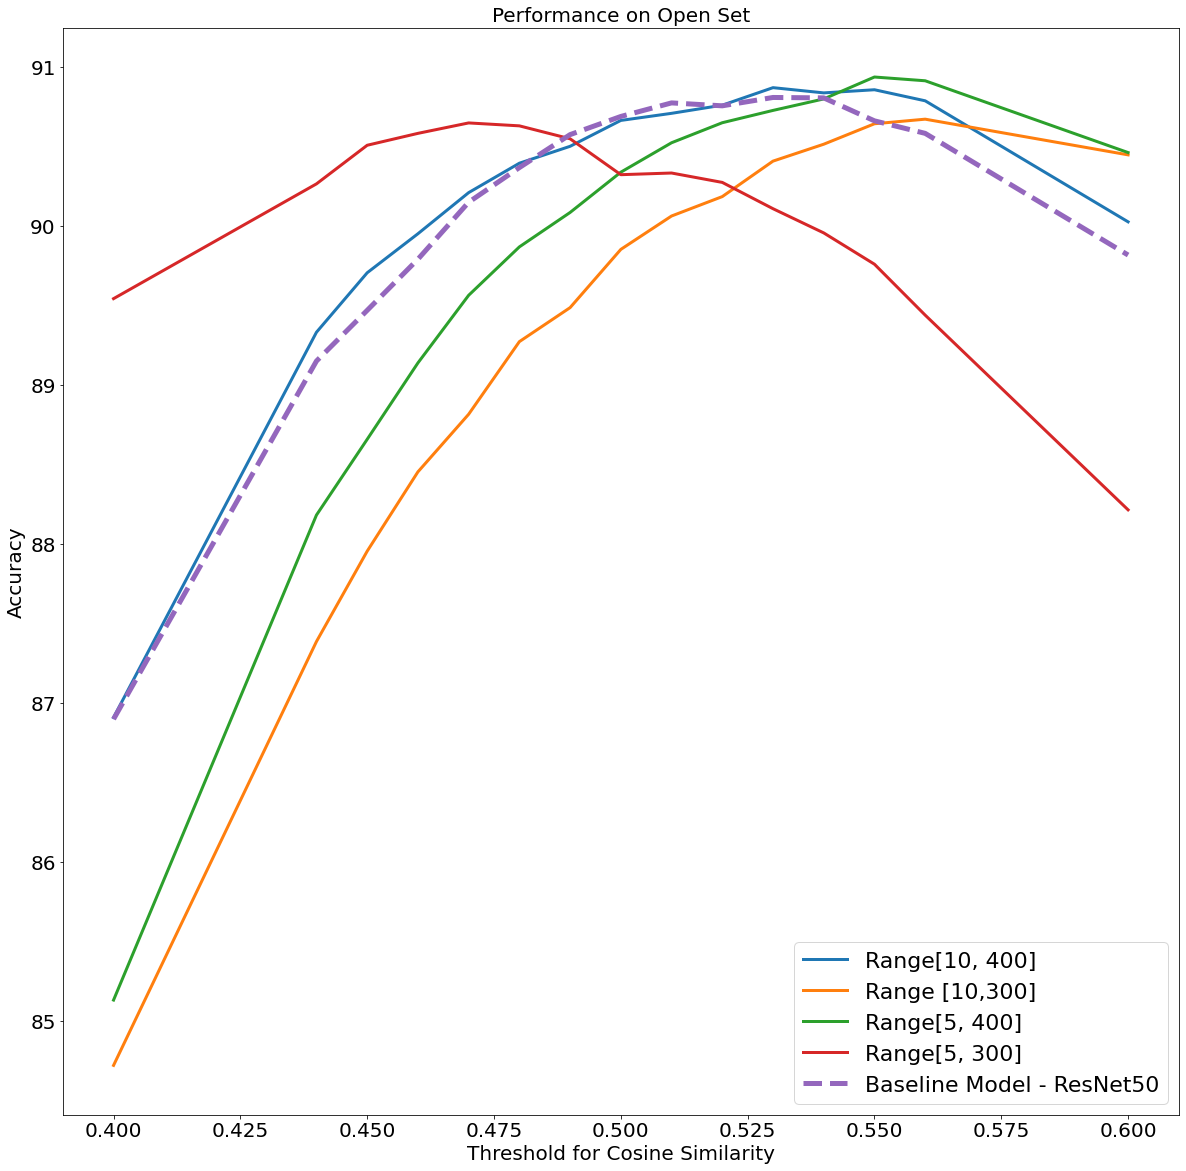

In [10]:
plt.figure(figsize=(20,20))
Threshold = [0.4, 0.44,0.45,0.46,0.47, 0.48,0.49, 0.50,0.51,0.52, 0.53,0.54, 0.55, 0.56, 0.60]

plt.plot(Threshold, Long_Tail_10_400, label = 'Range[10, 400]',linewidth = 3)
plt.plot(Threshold, Long_Tail_10_300, label = 'Range [10,300]',linewidth = 3)
plt.plot(Threshold, Long_Tail_5_400, label = 'Range[5, 400]',linewidth = 3)
plt.plot(Threshold, Long_Tail_5_300, label = 'Range[5, 300]',linewidth = 3)

plt.plot(Threshold, Baseline_Accuracy, label = 'Baseline Model - ResNet50', linewidth = 5, linestyle='--')

plt.xticks(fontsize = 20)
plt.yticks(fontsize= 20)

plt.xlabel('Threshold for Cosine Similarity', fontsize = 20)
plt.ylabel('Accuracy', fontsize = 20)
plt.title('Performance on Open Set',fontsize = 20)
plt.legend(fontsize=22)

In [14]:
np.arange(0.4,0.6,0.01)

array([0.4 , 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 ,
       0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59])